In [1]:
import matplotlib
%matplotlib inline
import pandas as pd

In [5]:
data = pd.read_csv("C:/Users/Seo/perfume7_include_brand.csv", header=None, names=['review', 'price', 'brand', 'name']) #read data

In [6]:
for ix, name in enumerate(data.columns):
    print(ix,name)

0 review
1 price
2 brand
3 name


In [7]:
data.head()

,review,price,brand,name
0,여름이여서 바깥 외출시에 향수를 뿌리면 주위에 향이 너무 쎄게 빨리 퍼지기 때문에 ...,"30,600",유즈,유즈 솔리드 퍼퓸 002 스테이포에버 30ml
1,아주 고급스런 비누향입니다. 손을 자주 씻는 직업이라... 목에서 귀 뒷부분으로 경...,"30,600",유즈,유즈 솔리드 퍼퓸 002 스테이포에버 30ml
2,예전에도 이런 류의 고체향수 몇개 써봤던 사람입니다! Sns 홍보를 많이해서 사봤는...,"30,600",유즈,유즈 솔리드 퍼퓸 002 스테이포에버 30ml
3,"유즈라는 브랜드 덕분에 고체향수를 알게되었고, 저번 올영체험단에서 헤어퍼퓸을 써보고...","30,600",유즈,유즈 솔리드 퍼퓸 002 스테이포에버 30ml
4,헐 !! 헐 !!!! 이거 모에요?? 그냥 혹시나 해서 구매 했는데.. 저 더 살...,"30,600",유즈,유즈 솔리드 퍼퓸 002 스테이포에버 30ml


In [8]:
data.review.shape
type(data.review)

pandas.core.series.Series

In [9]:
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
twitter_tag = Okt()

def tokenizer(str):
    return [token for token in twitter_tag.nouns(str) if len(token) > 1]

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(tokenizer=tokenizer, #우선은 명사만 사용
                      decode_error ='ignore', 
                      max_df=0.5, #너무 자주 나타나는 단어는 제외, 책에서는 0.15를 사용
                      #min_df = 3, #3개 미만의 문서에서 나타난 단어는 제외, 여기서는 max_features를 1000으로 제한하므로 별 필요 없음
                      max_features = 1000) #적당한 대상 단어 수를 선택
review_cv = vec.fit_transform(data.review)

In [11]:
review_cv.shape

(972, 1000)

In [12]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수를 지정
                                max_iter=25, #max_iter는 최종 모형에서는 5,000~10,000번 시도한다고 알려져 있음
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                #topic_word_prior: beta, doc_topic_prior: alpha
                                #일반적으로 beta는 0.1로 고정하고 alpha를 50/topic의 수 근처의 값을 시도
                                #alpha와 beta는 낮은 값을 사용할수록 특정 토픽들이 두드러지도록 하는 효과가 있다고 합
                                learning_method='batch', #'batch'는 'online'에 비해 더 성능이 좋고 느림, 현재는 default
                                n_jobs= -1, #사용 processor 수, None이면 1, -1이면 모두 사용
                                random_state=0)

review_topics = lda.fit_transform(review_cv)

In [13]:
print(review_topics.shape)
type(review_topics)

(972, 10)


numpy.ndarray

In [14]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(", ".join([feature_names[i]+'('+str(topic[i])+')' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

In [15]:
print_top_words(lda,vec.get_feature_names(), 10)

Topic #0: 냄새, 향수, 코튼, 뿌리, 클린, 사람, 호불호, 남자, 남자친구, 역시
Topic #1: 정도, 지속, 가격, 파우더, 그냥, 가지, 꽃향, 향수, 시간, 기대
Topic #2: 향수, 고체, 크림, 핸드, 타입, 제품, 승무원, 평소, 이건, 휴대
Topic #3: 진짜, 비누, 무난, 향수, 하나, 완전, 섬유, 유연제, 만족, 지속
Topic #4: 선물, 포장, 배송, 상품, 친구, 주문, 다만, 다음, 비누, 박스
Topic #5: 느낌, 향수, 비누, 아주, 사용, 기분, 부담, 살짝, 자주, 머리
Topic #6: 사용, 정말, 처음, 조금, 향수, 추천, 여름, 지속, 별로, 마음
Topic #7: 지속, 생각, 향기, 매장, 편이, 다른, 취향, 패키지, 고민, 마음
Topic #8: 머스크, 향수, 느낌, 잔향, 중성, 여성, 처음, 뿌리, 약간, 사용
Topic #9: 구매, 제품, 보고, 구입, 광고, 올리브영, 한번, 샘플, 후기, 온라인



In [16]:
trend_data = pd.DataFrame(review_topics, columns=['topic'+str(i) for i in range(1, 11)])

In [17]:
trend_data.head()

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
0,0.017259,0.476744,0.145779,0.028009,0.010132,0.085035,0.113548,0.015656,0.019021,0.088817
1,0.020920,0.123638,0.162582,0.156902,0.020879,0.216018,0.073382,0.108210,0.095065,0.022402
2,0.033875,0.167057,0.134790,0.391035,0.033236,0.082941,0.035975,0.022170,0.074414,0.024507
3,0.031016,0.077663,0.275120,0.014770,0.021867,0.029076,0.050194,0.430814,0.020733,0.048748
4,0.133998,0.131255,0.330351,0.162287,0.049135,0.026998,0.031975,0.020392,0.031081,0.082528


In [20]:
trend_data = pd.concat([trend_data, data.brand], axis=1)

In [21]:
trend_data.shape

(972, 11)

In [22]:
trend_data.head()

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,brand
0,0.017259,0.476744,0.145779,0.028009,0.010132,0.085035,0.113548,0.015656,0.019021,0.088817,유즈
1,0.020920,0.123638,0.162582,0.156902,0.020879,0.216018,0.073382,0.108210,0.095065,0.022402,유즈
2,0.033875,0.167057,0.134790,0.391035,0.033236,0.082941,0.035975,0.022170,0.074414,0.024507,유즈
3,0.031016,0.077663,0.275120,0.014770,0.021867,0.029076,0.050194,0.430814,0.020733,0.048748,유즈
4,0.133998,0.131255,0.330351,0.162287,0.049135,0.026998,0.031975,0.020392,0.031081,0.082528,유즈


In [24]:
trend = trend_data.groupby(['brand']).mean()

In [25]:
trend.shape

(3, 10)

In [26]:
trend.head()

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
brand,,,,,,,,,,
나르시소 로드리게즈,0.090660,0.081956,0.075956,0.087699,0.073200,0.083123,0.112530,0.097038,0.205050,0.092788
유즈,0.072352,0.112398,0.145351,0.083534,0.083588,0.106807,0.101947,0.097821,0.085665,0.110538
클린,0.123819,0.086011,0.084253,0.105585,0.114266,0.096078,0.103137,0.097535,0.083159,0.106157


In [27]:
len(set(trend_data.brand))

3

In [28]:
#jupyter에서 matplotlib을 사용해 만든 graph를 화면에 표시하기 위해 필요
%matplotlib inline 

import matplotlib.pyplot as plt

#아래는 한글을 사용할 때 깨지는 문제에 대한 해결
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

#그래프의 축 등에서 음수를 표시할 때 minus sign이 깨지는 것 해결
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

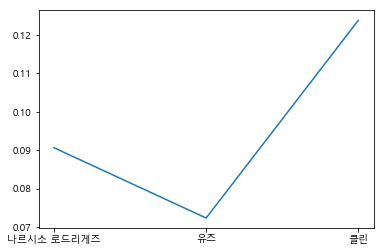

In [29]:
plt.plot(trend.index[:100], trend.topic1[:100])
plt.show()